# Predicting rent prices in Florianópolis with Python

This simple project is a toy problem used to evaluate Python and R differences for Data Science. Our goal is not the accuracy of the prediction, but the process of getting there. For this, we will:

- Query JSON from an API
- Parse the JSON into a CSV file
- Clean the data
- Explore some graphs
- Create a simple prediction model
- Plot the results

## Querying the JSON api

For this analysis, we will use [Viva Real API](http://api.vivareal.com/), a [real state portal](www.vivareal.com.br).

The code to download and process the APi can be found at [prepare.py](/prepare.py)

In [3]:
import requests, json
import unicodecsv as csv

def perform_paged_request(page):
    """
    Query a single page of the Viva Real API.

    :param page the page index to be queried

    :return a dictionary representation of the data queried
    """
    url = "http://api.vivareal.com/api/1.0/locations/listings"
    params = {
        "apiKey": "183d98b9-fc81-4ef1-b841-7432c610b36e",
        "exactLocation": False,
        "currency": "BRL",
        "business": "RENTA",
        "listingType": "APART",
        "listingUse": "RESIDENCIAL",
        "rankingId":0,
        "locationIds": "BR>Santa Catarina>NULL>Florianopolis",
        "maxResults": 40,
        "page": page
    }

    response = requests.get(url, params=params)
    return json.loads(response.content)

def load_data(max  = 100):
    """
    Loads Viva Real API listings
    :param max max number of pages to load
    """

    current_page = 1

    data = perform_paged_request(current_page)
    print data
    listings = []

    while current_page < max and data and data["listings"]:
        print current_page
        listings = listings+data["listings"]
        current_page += 1
        data = perform_paged_request(current_page)

    return listings

Extracting info in this case is a simple pluck operation. We could do something more intelligent, like exapnding the `extraFeatures` properties to a boolean table, but for now let's focus on the basics.

In [4]:
def extractInfo(listings):

    keys = ["propertyId", "rentPrice", "area", "bathrooms", "rooms",
            "garages", "latitude", "longitude", "address", "suites",
            "rentPeriodId", "condominiumPrice", "iptu"]

    return keys, [{k: rental[k] for k in keys} for rental in listings]

The process can be run using the following:

In [5]:
# with open("rentals_test.csv", "w") as csvFile:
#    data = load_data(max=1)
#    keys, data = extractInfo(data)
#    writer = csv.DictWriter(csvFile, encoding="utf-8", fieldnames=keys, quoting=csv.QUOTE_ALL)
#    writer.writeheader()
#    writer.writerows(data)

## Loading and exploring the dataset

After creating the CSV, we can now start analysing the data. For this, we will use `numpy`, `scipy`, `matplotlib` and `pandas`.



In [20]:
%matplotlib inline
import pandas as pd, numpy as np, statsmodels.formula.api as sm
import matplotlib, matplotlib.pyplot as plt, numpy as np
matplotlib.style.use('ggplot')

data = pd.read_csv("rentals.csv")

data.describe()

,propertyId,rentPrice,area,bathrooms,rooms,garages,latitude,longitude,suites,condominiumPrice,iptu
count,2.890000e+03,2890.000000,1499.000000,2890.000000,2890.000000,2890.000000,2890.000000,2890.000000,2890.000000,1163.000000,896.000000
mean,5.930600e+07,1035.133564,97.433883,1.460900,1.949827,1.080623,-28.334238,-47.551155,0.633564,388.061909,145.025670
std,6.804912e+06,2945.018752,561.462110,0.834544,0.881667,3.813324,4.401575,4.726919,0.759147,339.387848,366.118136
min,3.687362e+07,100.000000,1.000000,0.000000,0.000000,0.000000,-48.406512,-50.218856,0.000000,0.000000,0.000000
25%,5.478710e+07,360.000000,55.000000,1.000000,1.000000,1.000000,-27.593236,-48.524904,0.000000,160.000000,0.000000
50%,6.098919e+07,650.000000,74.000000,1.000000,2.000000,1.000000,-27.437144,-48.458217,1.000000,362.000000,53.000000
75%,6.551900e+07,1300.000000,100.000000,2.000000,3.000000,1.000000,-27.422163,-48.422043,1.000000,520.500000,108.000000
max,6.693107e+07,150000.000000,21723.000000,6.000000,5.000000,203.000000,0.000000,0.000000,5.000000,4528.000000,5564.000000


We are going to define some contraints in our data
- `rentPeriodId`: we want only monthly rents.
- `rentPrice`: the rent should be less than R$4000 per month. This avoid outliers, and we are not rich either way.
- `latitude` should be between -28 and -27
- `longitude` should be between -49 and -48
- should have at least 1 `bathroom`
- should have at least 1 `room`

In [21]:
data =data[(data.rentPeriodId=="MON") & (data.latitude.between(-28, -27)) & (data.longitude.between(-49, -48))
           & (data.bathrooms > 0) & (data.rooms > 0) & (data.rentPrice <4000) ]

#### Rentprice distribution

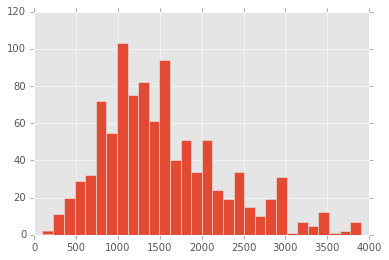

In [22]:
data.rentPrice.hist(bins=30)

#### Entries location

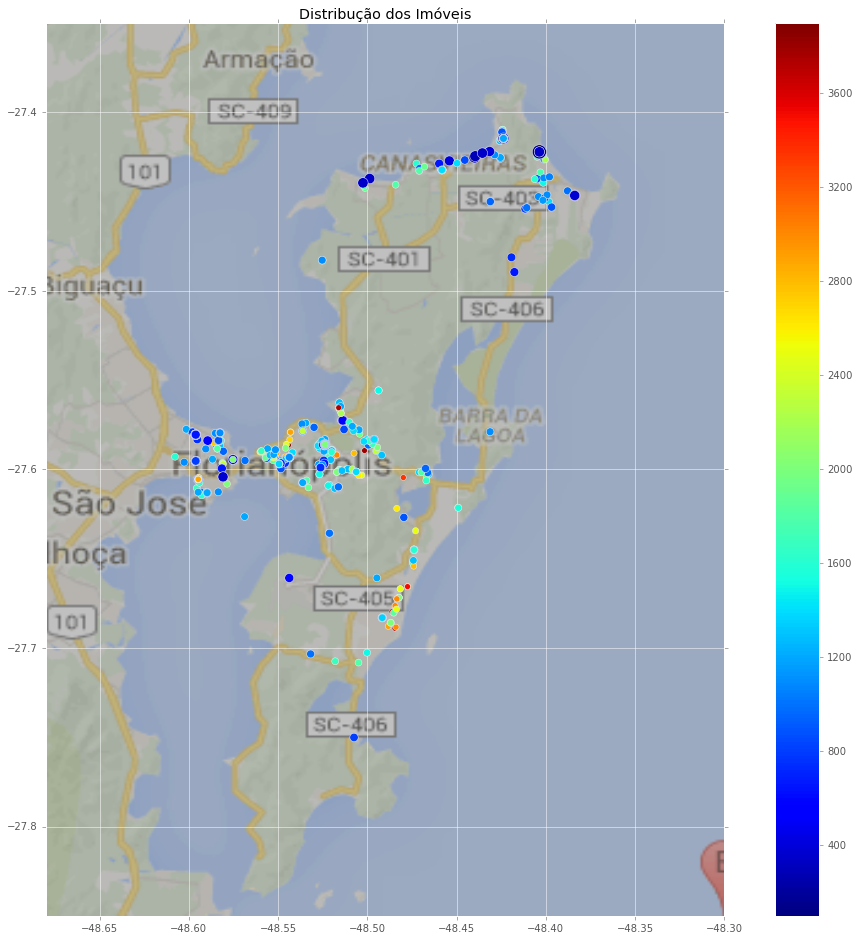

In [24]:
def plot_scater_map(data):
    """
    Plots a map and the location of each rental unit at their coordinates.
    The colormap represents the rental price. Size of the points is inversely
    proportional to the price.

    :param data: the rental units tho be shown in the map
    """
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    im = matplotlib.image.imread('flnp2.png');
    im[:, :, -1] = 0.7;
    plt.imshow(im, extent=[-48.68, -48.3, -27.85, -27.35])
    plt.scatter(data.longitude,
                data.latitude,
                c=data.rentPrice,
                s = 2000/np.sqrt(data.rentPrice))

    plt.colorbar()
    plt.axis([-48.68, -48.3, -27.85, -27.35])
    plt.title(u"Distribução dos Imóveis")
    
plot_scater_map(data)

## Generating the model

We will create a very simple prediction algorithm: a linear model using *rooms*, *bathrooms*, *latitude*, *longitude*, *garages*, *area*, using 70% of the data for the train set. We should also scale the data, maybe some other time.

In [40]:
np.random.seed(42) # fixed randomness

rds = np.random.random(len(data))
train_data, test_data = data[rds < 0.7], data[rds >= 0.7]

# Simple prediction

result = sm.ols(formula="rentPrice ~ rooms + bathrooms + latitude + longitude + garages", data = train_data).fit()


## Results

In [41]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rentPrice   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     152.3
Date:                Wed, 13 Apr 2016   Prob (F-statistic):          1.38e-109
Time:                        12:48:49   Log-Likelihood:                -5411.5
No. Observations:                 711   AIC:                         1.084e+04
Df Residuals:                     705   BIC:                         1.086e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5.033e+04   1.73e+04      2.904      0.004      1.63e+04  8.44e+04
rooms        273.3772     30.663      8.915      0.000       213.175   333.580
bathrooms    273.7540     33.296      8.222      0.000       208.383   339.125
latitude   -4157.4522    372.692    -11.155      0.000     -4889.171 -3425.733
longitude   3395.0947    458.644      7.402      0.000      2494.622  4295.567
garages      292.1647     34.404      8.492      0.000       224.619   359.711
==============================================================================
Omnibus:                       38.930   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.423
Skew:                           0.465   Prob(JB):                     1.52e-12
Kurtosis:                       3.986   Cond. No.                     5.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared of 0.519 means a very poor model. But that's ok. We probably could do much better by chosing better variables, and a better algorithm, but that's not why we are here. We are hee for preety graphs.

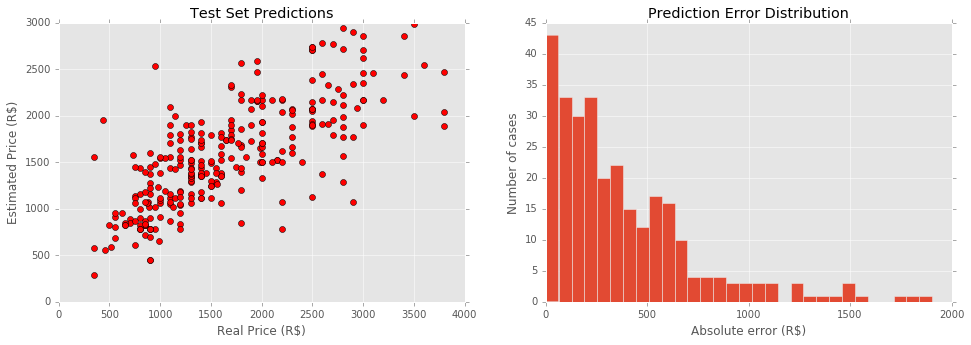

In [50]:
def plot_results(expected, received):
    """
    Displays the result of the computed model.

    :param expected the actual value of the rental price
    :param received the value estimated by the model
    """
    plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.plot(expected, received, 'ro')
    plt.xlabel(u"Real Price (R$)")
    plt.ylabel(u"Estimated Price (R$)")
    plt.title(u"Test Set Predictions")

    plt.subplot(122)
    plt.hist(np.abs(expected - received), bins=30)
    plt.ylabel(u"Number of cases")
    plt.xlabel(u"Absolute error (R$)")
    plt.title(u"Prediction Error Distribution")
    
plot_results(test_data.rentPrice, result.predict(test_data))